In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Data Loading and Initial Exploration


In [2]:
# Load the data
customers = pd.read_csv('../MILESTONE 1/data/customers.csv')
transactions = pd.read_csv('../MILESTONE 1/data/transactions.csv')

print("Customers dataset shape:", customers.shape)
print("Transactions dataset shape:", transactions.shape)
print("\nCustomers columns:", customers.columns.tolist())
print("Transactions columns:", transactions.columns.tolist())


Customers dataset shape: (4380, 2)
Transactions dataset shape: (406829, 8)

Customers columns: ['CustomerID', 'Country']
Transactions columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [3]:
# Merge datasets
df = pd.merge(transactions, customers, on='CustomerID', how='inner')
print("Merged dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()


Merged dataset shape: (407755, 9)

First few rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country_x,Country_y
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,United Kingdom


In [4]:
# Data cleaning and preprocessing
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Remove negative quantities (returns)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

print("After cleaning:")
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())


After cleaning:
Dataset shape: (398793, 10)

Data types:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country_x              object
Country_y              object
Revenue               float64
dtype: object

Missing values:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country_x      0
Country_y      0
Revenue        0
dtype: int64


## 2. Feature Engineering for Customer Behavior Analysis


In [5]:
# Create customer-level features for clustering
customer_features = df.groupby('CustomerID').agg({
    'Quantity': ['sum', 'mean', 'std'],
    'UnitPrice': ['mean', 'std'],
    'Revenue': ['sum', 'mean', 'std'],
    'InvoiceNo': 'nunique',  # Number of unique invoices (frequency)
    'InvoiceDate': ['min', 'max']
}).round(2)

# Flatten column names
customer_features.columns = ['_'.join(col).strip() for col in customer_features.columns]

# Calculate additional features
customer_features['days_active'] = (customer_features['InvoiceDate_max'] - customer_features['InvoiceDate_min']).dt.days
customer_features['avg_order_value'] = customer_features['Revenue_sum'] / customer_features['InvoiceNo_nunique']
customer_features['avg_items_per_order'] = customer_features['Quantity_sum'] / customer_features['InvoiceNo_nunique']

# Remove date columns as they're not needed for clustering
customer_features = customer_features.drop(['InvoiceDate_min', 'InvoiceDate_max'], axis=1)

print("Customer features shape:", customer_features.shape)
print("\nFeature columns:")
print(customer_features.columns.tolist())
print("\nFirst few rows:")
customer_features.head()


Customer features shape: (4338, 12)

Feature columns:
['Quantity_sum', 'Quantity_mean', 'Quantity_std', 'UnitPrice_mean', 'UnitPrice_std', 'Revenue_sum', 'Revenue_mean', 'Revenue_std', 'InvoiceNo_nunique', 'days_active', 'avg_order_value', 'avg_items_per_order']

First few rows:


,Quantity_sum,Quantity_mean,Quantity_std,UnitPrice_mean,UnitPrice_std,Revenue_sum,Revenue_mean,Revenue_std,InvoiceNo_nunique,days_active,avg_order_value,avg_items_per_order
CustomerID,,,,,,,,,,,,
12346.0,74215,74215.00,NaN,1.04,NaN,77183.60,77183.60,NaN,1,0,77183.600000,74215.000000
12347.0,2458,13.51,18.86,2.64,2.26,4310.00,23.68,23.29,7,365,615.714286,351.142857
12348.0,2341,75.52,51.09,5.76,13.40,1797.24,57.98,48.51,4,282,449.310000,585.250000
12349.0,631,8.64,6.98,8.29,35.03,1757.55,24.08,34.66,1,0,1757.550000,631.000000
12350.0,197,11.59,4.35,3.84,9.33,334.40,19.67,7.28,1,0,334.400000,197.000000


In [6]:
# Handle missing values and infinite values
customer_features = customer_features.replace([np.inf, -np.inf], np.nan)
customer_features = customer_features.fillna(customer_features.median())

print("After handling missing values:")
print("Missing values:", customer_features.isnull().sum().sum())
print("\nDataset shape:", customer_features.shape)
print("\nBasic statistics:")
customer_features.describe()


After handling missing values:
Missing values: 0

Dataset shape: (4338, 12)

Basic statistics:


,Quantity_sum,Quantity_mean,Quantity_std,UnitPrice_mean,UnitPrice_std,Revenue_sum,Revenue_mean,Revenue_std,InvoiceNo_nunique,days_active,avg_order_value,avg_items_per_order
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,1194.168050,45.065537,27.658167,4.467697,4.364094,2059.877056,68.350452,50.816448,4.272015,130.448594,420.160944,254.018877
std,5047.093512,1203.438033,712.732740,34.211453,18.702669,8991.638573,1467.918896,1515.886682,7.697998,132.039554,1796.839912,1313.034190
min,1.000000,1.000000,0.000000,0.120000,0.000000,3.750000,2.100000,0.000000,1.000000,0.000000,3.450000,1.000000
25%,160.000000,6.000000,4.990000,2.200000,1.820000,307.415000,12.370000,5.992500,1.000000,0.000000,178.625000,93.000000
50%,379.000000,10.000000,7.620000,2.920000,2.630000,674.485000,17.725000,9.710000,2.000000,92.500000,294.267500,162.000000
75%,993.000000,14.670000,12.580000,3.830000,3.560000,1662.170000,24.857500,19.117500,5.000000,251.750000,430.957143,272.000000
max,196915.000000,74215.000000,46761.910000,2033.100000,602.440000,280206.020000,77183.600000,97265.130000,209.000000,373.000000,84236.250000,74215.000000


## 3. Feature Selection and Preparation for Clustering


In [7]:
# Select relevant numerical features for clustering
selected_features = [
    'Quantity_sum',      # Total quantity purchased
    'Quantity_mean',     # Average quantity per transaction
    'UnitPrice_mean',    # Average unit price
    'Revenue_sum',       # Total revenue
    'Revenue_mean',      # Average revenue per transaction
    'InvoiceNo_nunique', # Number of orders (frequency)
    'days_active',       # Customer lifetime
    'avg_order_value',   # Average order value
    'avg_items_per_order' # Average items per order
]

X = customer_features[selected_features].copy()
print("Selected features for clustering:")
print(X.columns.tolist())
print("\nDataset shape:", X.shape)
print("\nFeature statistics:")
X.describe()


Selected features for clustering:
['Quantity_sum', 'Quantity_mean', 'UnitPrice_mean', 'Revenue_sum', 'Revenue_mean', 'InvoiceNo_nunique', 'days_active', 'avg_order_value', 'avg_items_per_order']

Dataset shape: (4338, 9)

Feature statistics:


,Quantity_sum,Quantity_mean,UnitPrice_mean,Revenue_sum,Revenue_mean,InvoiceNo_nunique,days_active,avg_order_value,avg_items_per_order
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,1194.168050,45.065537,4.467697,2059.877056,68.350452,4.272015,130.448594,420.160944,254.018877
std,5047.093512,1203.438033,34.211453,8991.638573,1467.918896,7.697998,132.039554,1796.839912,1313.034190
min,1.000000,1.000000,0.120000,3.750000,2.100000,1.000000,0.000000,3.450000,1.000000
25%,160.000000,6.000000,2.200000,307.415000,12.370000,1.000000,0.000000,178.625000,93.000000
50%,379.000000,10.000000,2.920000,674.485000,17.725000,2.000000,92.500000,294.267500,162.000000
75%,993.000000,14.670000,3.830000,1662.170000,24.857500,5.000000,251.750000,430.957143,272.000000
max,196915.000000,74215.000000,2033.100000,280206.020000,77183.600000,209.000000,373.000000,84236.250000,74215.000000


In [8]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("After standardization:")
print("Mean values:", X_scaled_df.mean().round(3))
print("\nStandard deviation values:", X_scaled_df.std().round(3))
print("\nFirst few rows:")
X_scaled_df.head()


After standardization:
Mean values: Quantity_sum           0.0
Quantity_mean         -0.0
UnitPrice_mean         0.0
Revenue_sum           -0.0
Revenue_mean          -0.0
InvoiceNo_nunique      0.0
days_active            0.0
avg_order_value        0.0
avg_items_per_order    0.0
dtype: float64

Standard deviation values: Quantity_sum           1.0
Quantity_mean          1.0
UnitPrice_mean         1.0
Revenue_sum            1.0
Revenue_mean           1.0
InvoiceNo_nunique      1.0
days_active            1.0
avg_order_value        1.0
avg_items_per_order    1.0
dtype: float64

First few rows:


,Quantity_sum,Quantity_mean,UnitPrice_mean,Revenue_sum,Revenue_mean,InvoiceNo_nunique,days_active,avg_order_value,avg_items_per_order
CustomerID,,,,,,,,,
12346.0,14.469565,61.638807,-0.100203,8.355806,52.539782,-0.425097,-0.988065,42.726282,56.334792
12347.0,0.250437,-0.026224,-0.053430,0.250275,-0.030435,0.354417,1.776577,0.108844,0.073978
12348.0,0.227252,0.025309,0.037778,-0.029212,-0.007066,-0.035340,1.147905,0.016224,0.252293
12349.0,-0.111596,-0.030271,0.111739,-0.033627,-0.030162,-0.425097,-0.988065,0.744386,0.287140
12350.0,-0.197596,-0.027820,-0.018350,-0.191920,-0.033167,-0.425097,-0.988065,-0.047734,-0.043430


In [9]:
# Apply PCA for dimensionality reduction
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print("Explained variance ratio:")
for i, (var, cum_var) in enumerate(zip(explained_variance_ratio, cumulative_variance_ratio)):
    print(f"PC{i+1}: {var:.3f} (Cumulative: {cum_var:.3f})")

# Use first 2 components for visualization
X_pca_2d = X_pca[:, :2]
print(f"\nFirst 2 components explain {cumulative_variance_ratio[1]:.3f} of variance")


Explained variance ratio:
PC1: 0.471 (Cumulative: 0.471)
PC2: 0.250 (Cumulative: 0.720)
PC3: 0.112 (Cumulative: 0.832)
PC4: 0.098 (Cumulative: 0.930)
PC5: 0.043 (Cumulative: 0.973)
PC6: 0.016 (Cumulative: 0.990)
PC7: 0.007 (Cumulative: 0.997)
PC8: 0.003 (Cumulative: 1.000)
PC9: 0.000 (Cumulative: 1.000)

First 2 components explain 0.720 of variance


## 4. K-Means Clustering


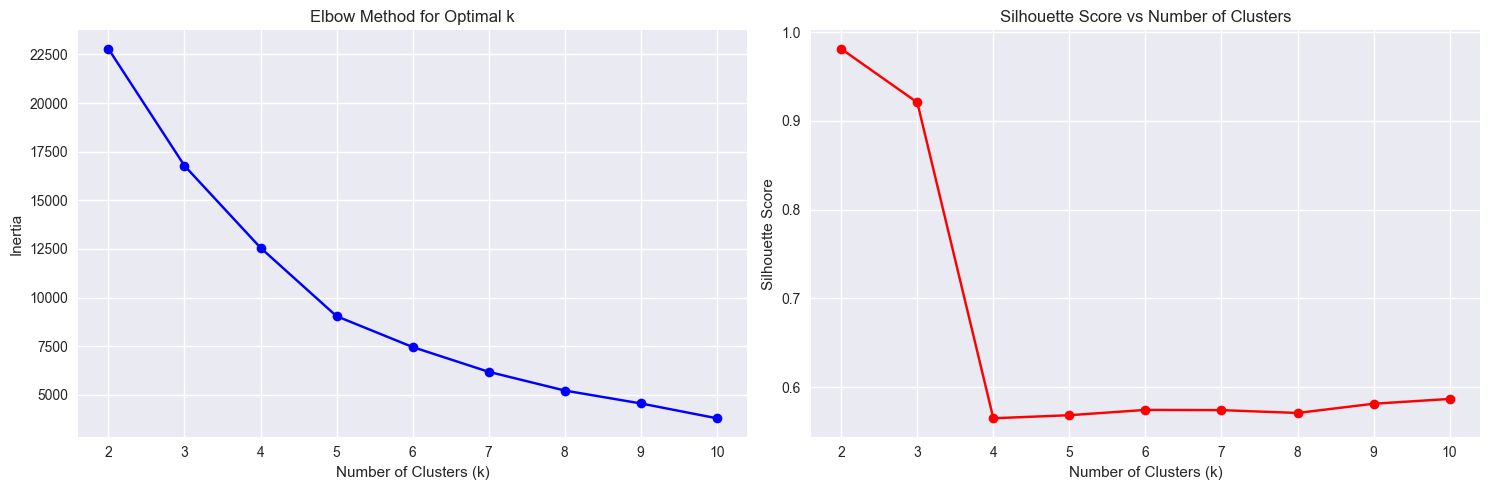

Silhouette scores:
k=2: 0.981
k=3: 0.921
k=4: 0.565
k=5: 0.568
k=6: 0.574
k=7: 0.574
k=8: 0.571
k=9: 0.581
k=10: 0.587


In [10]:
# Determine optimal number of clusters using Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

# Plot Elbow Method
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)

plt.tight_layout()
plt.savefig('visualizations/elbow_silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

print("Silhouette scores:")
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.3f}")


In [11]:
# Choose optimal k based on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

# Apply K-Means with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to the dataset
customer_features['kmeans_cluster'] = kmeans_labels

print(f"\nCluster distribution:")
print(customer_features['kmeans_cluster'].value_counts().sort_index())


Optimal number of clusters: 2
Best silhouette score: 0.981

Cluster distribution:
kmeans_cluster
0    4336
1       2
Name: count, dtype: int64


## 5. DBSCAN Clustering


In [12]:
# Experiment with different DBSCAN parameters
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples_values = [5, 10, 15, 20]

best_eps = None
best_min_samples = None
best_score = -1
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        
        # Calculate silhouette score (excluding noise points)
        if len(set(dbscan_labels)) > 1 and -1 not in dbscan_labels:
            score = silhouette_score(X_scaled, dbscan_labels)
        elif len(set(dbscan_labels)) > 2:  # More than 1 cluster + noise
            # Remove noise points for silhouette calculation
            mask = dbscan_labels != -1
            if len(set(dbscan_labels[mask])) > 1:
                score = silhouette_score(X_scaled[mask], dbscan_labels[mask])
            else:
                score = -1
        else:
            score = -1
        
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette_score': score
        })
        
        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_samples

# Display results
results_df = pd.DataFrame(results)
print("DBSCAN Parameter Tuning Results:")
print(results_df.sort_values('silhouette_score', ascending=False).head(10))


DBSCAN Parameter Tuning Results:
   eps  min_samples  n_clusters  n_noise  silhouette_score
8  1.5            5           2       51          0.734953
4  1.0            5           2       70          0.604943
0  0.5            5           3      134          0.372424
1  0.5           10           1      159         -1.000000
3  0.5           20           1      194         -1.000000
2  0.5           15           1      174         -1.000000
6  1.0           15           1       87         -1.000000
5  1.0           10           1       81         -1.000000
7  1.0           20           1       87         -1.000000
9  1.5           10           1       56         -1.000000


In [13]:
# Apply DBSCAN with best parameters
print(f"Best parameters: eps={best_eps}, min_samples={best_min_samples}")
print(f"Best silhouette score: {best_score:.3f}")

dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan_final.fit_predict(X_scaled)

# Add DBSCAN cluster labels to the dataset
customer_features['dbscan_cluster'] = dbscan_labels

print(f"\nDBSCAN Cluster distribution:")
print(customer_features['dbscan_cluster'].value_counts().sort_index())
print(f"\nNoise points: {list(dbscan_labels).count(-1)}")


Best parameters: eps=1.5, min_samples=5
Best silhouette score: 0.735

DBSCAN Cluster distribution:
dbscan_cluster
-1      51
 0    4284
 1       3
Name: count, dtype: int64

Noise points: 51


## 6. Visualization of Clustering Results


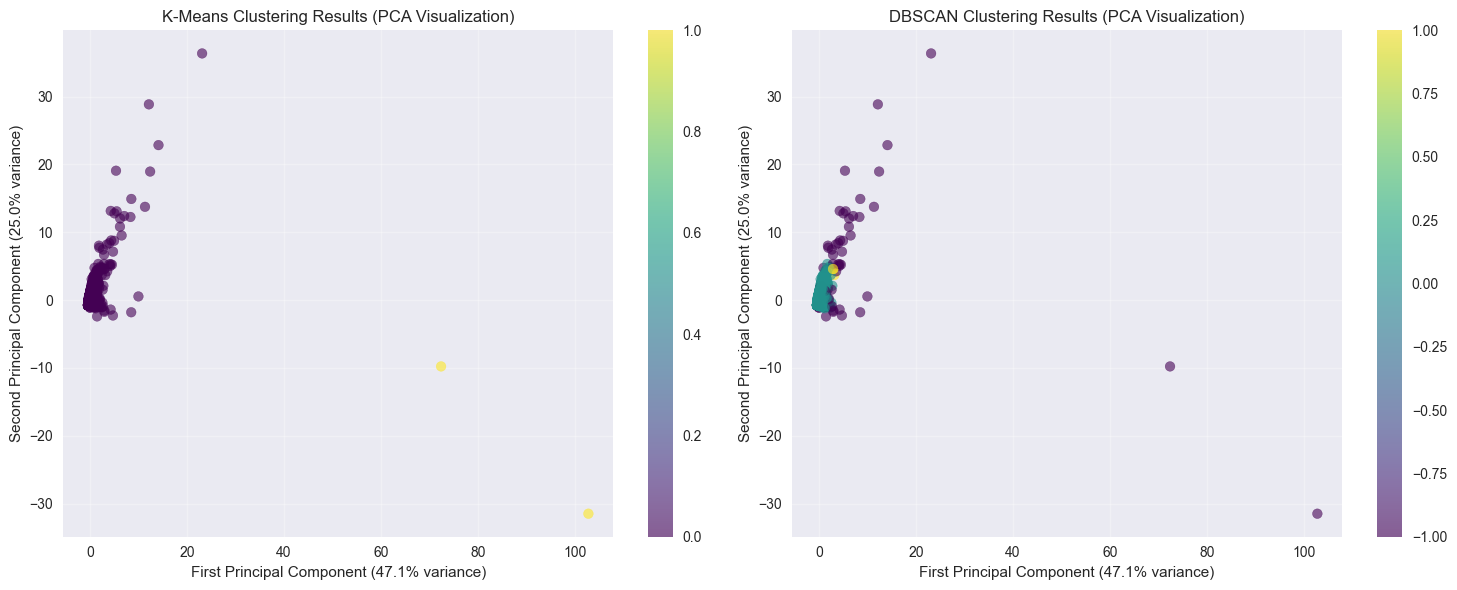

In [14]:
# 1. Scatter Plot (2D using PCA) - K-Means
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.xlabel(f'First Principal Component ({explained_variance_ratio[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component ({explained_variance_ratio[1]:.1%} variance)')
plt.title('K-Means Clustering Results (PCA Visualization)')
plt.colorbar(scatter)
plt.grid(True, alpha=0.3)

# 2. Scatter Plot (2D using PCA) - DBSCAN
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
plt.xlabel(f'First Principal Component ({explained_variance_ratio[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component ({explained_variance_ratio[1]:.1%} variance)')
plt.title('DBSCAN Clustering Results (PCA Visualization)')
plt.colorbar(scatter)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/cluster_scatter.png', dpi=300, bbox_inches='tight')
plt.show()


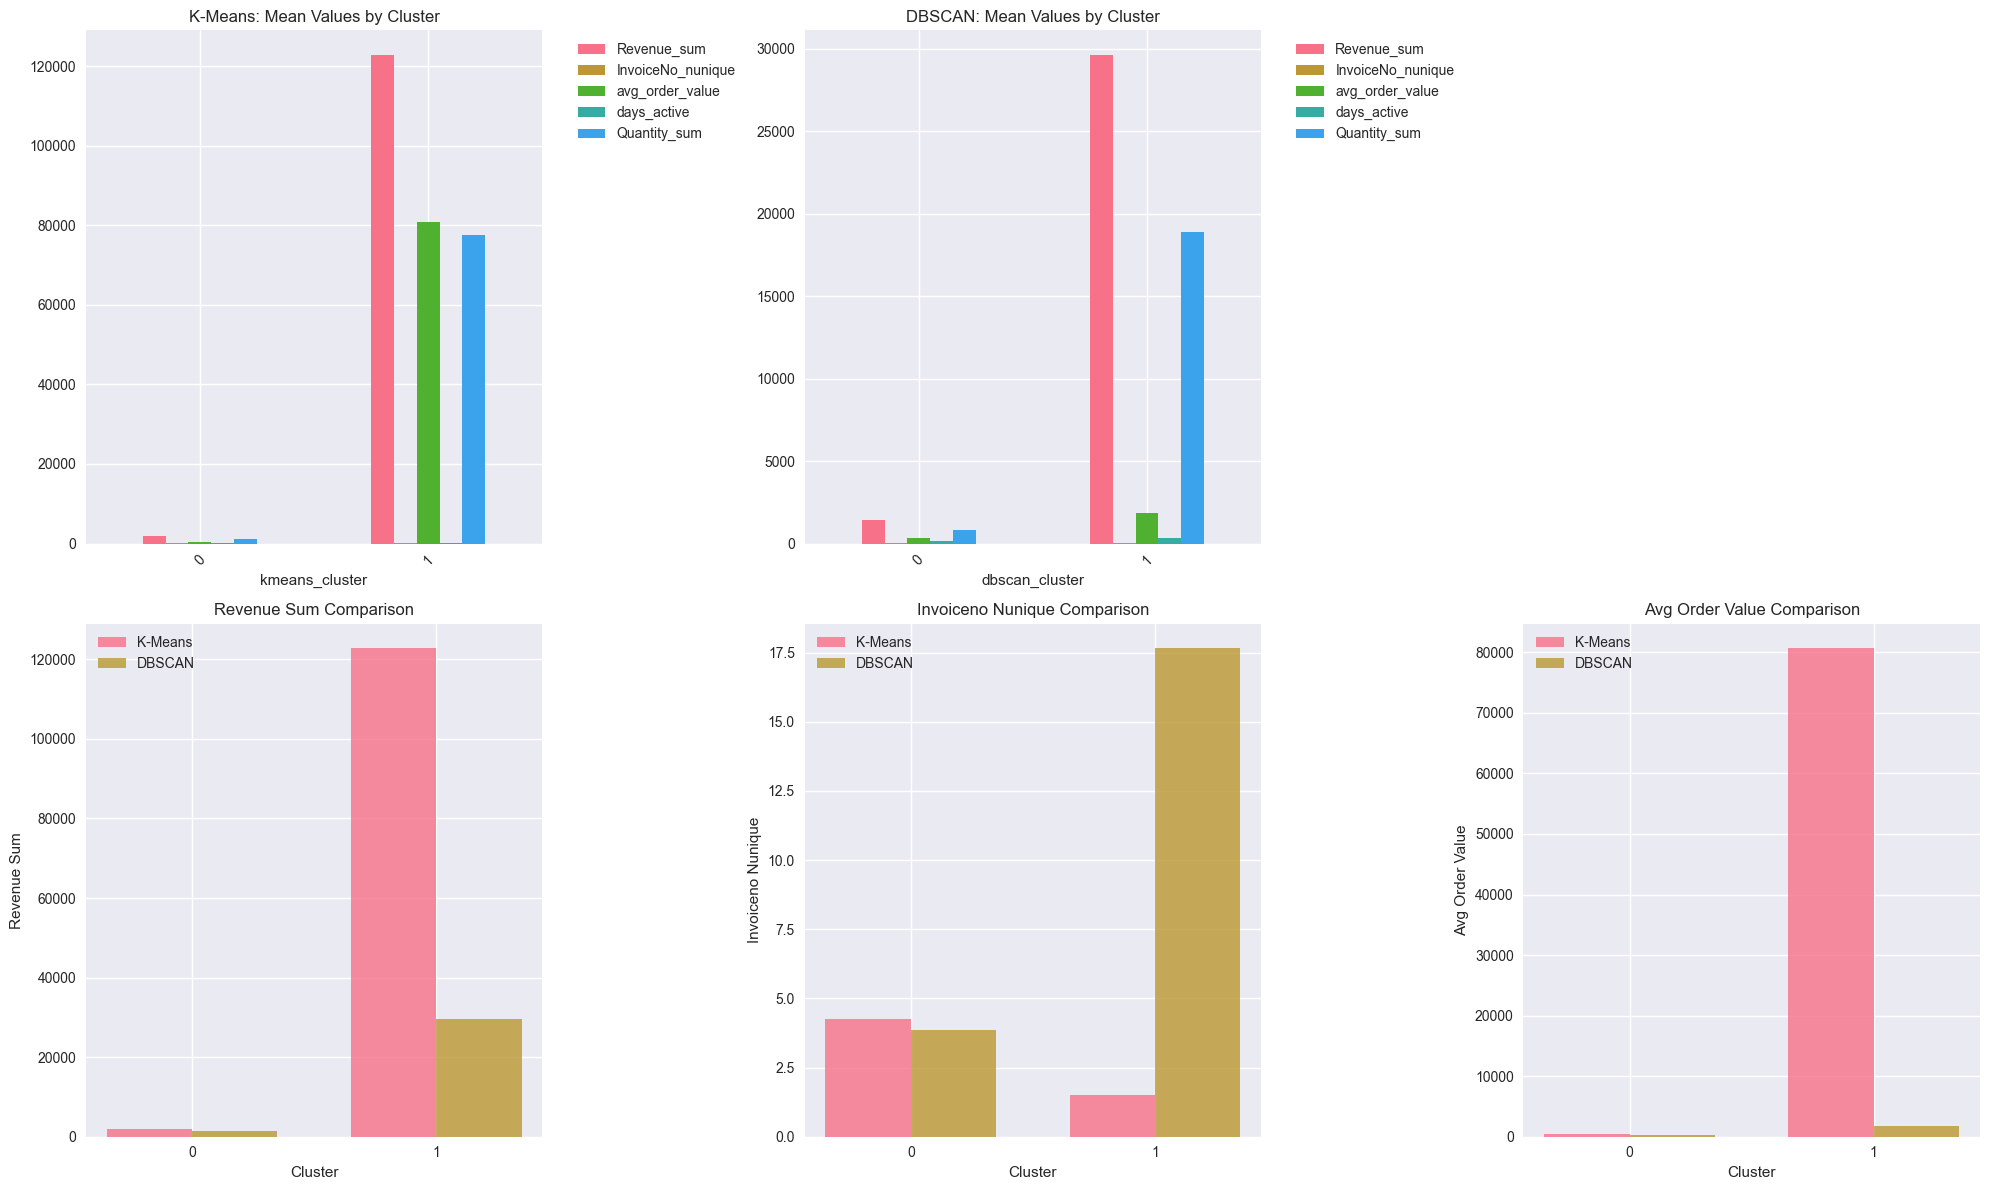

In [15]:
# 2. Cluster Characteristics - Bar plots showing mean of key metrics per cluster
plt.figure(figsize=(20, 12))

# Key metrics for cluster analysis
key_metrics = ['Revenue_sum', 'InvoiceNo_nunique', 'avg_order_value', 'days_active', 'Quantity_sum']

# K-Means cluster characteristics
plt.subplot(2, 3, 1)
kmeans_cluster_means = customer_features.groupby('kmeans_cluster')[key_metrics].mean()
kmeans_cluster_means.plot(kind='bar', ax=plt.gca())
plt.title('K-Means: Mean Values by Cluster')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# DBSCAN cluster characteristics (excluding noise)
plt.subplot(2, 3, 2)
dbscan_clusters = customer_features[customer_features['dbscan_cluster'] != -1]
if len(dbscan_clusters) > 0:
    dbscan_cluster_means = dbscan_clusters.groupby('dbscan_cluster')[key_metrics].mean()
    dbscan_cluster_means.plot(kind='bar', ax=plt.gca())
    plt.title('DBSCAN: Mean Values by Cluster')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Individual metric comparisons
for i, metric in enumerate(key_metrics[:3]):
    plt.subplot(2, 3, i+4)
    
    # K-Means
    kmeans_means = customer_features.groupby('kmeans_cluster')[metric].mean()
    
    # DBSCAN (excluding noise)
    if len(dbscan_clusters) > 0:
        dbscan_means = dbscan_clusters.groupby('dbscan_cluster')[metric].mean()
        
        x = np.arange(len(kmeans_means))
        width = 0.35
        
        plt.bar(x - width/2, kmeans_means.values, width, label='K-Means', alpha=0.8)
        plt.bar(x + width/2, dbscan_means.values, width, label='DBSCAN', alpha=0.8)
        
        plt.xlabel('Cluster')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.title(f'{metric.replace("_", " ").title()} Comparison')
        plt.legend()
        plt.xticks(x, kmeans_means.index)

plt.tight_layout()
plt.savefig('visualizations/cluster_profile_bar.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1500x1000 with 0 Axes>

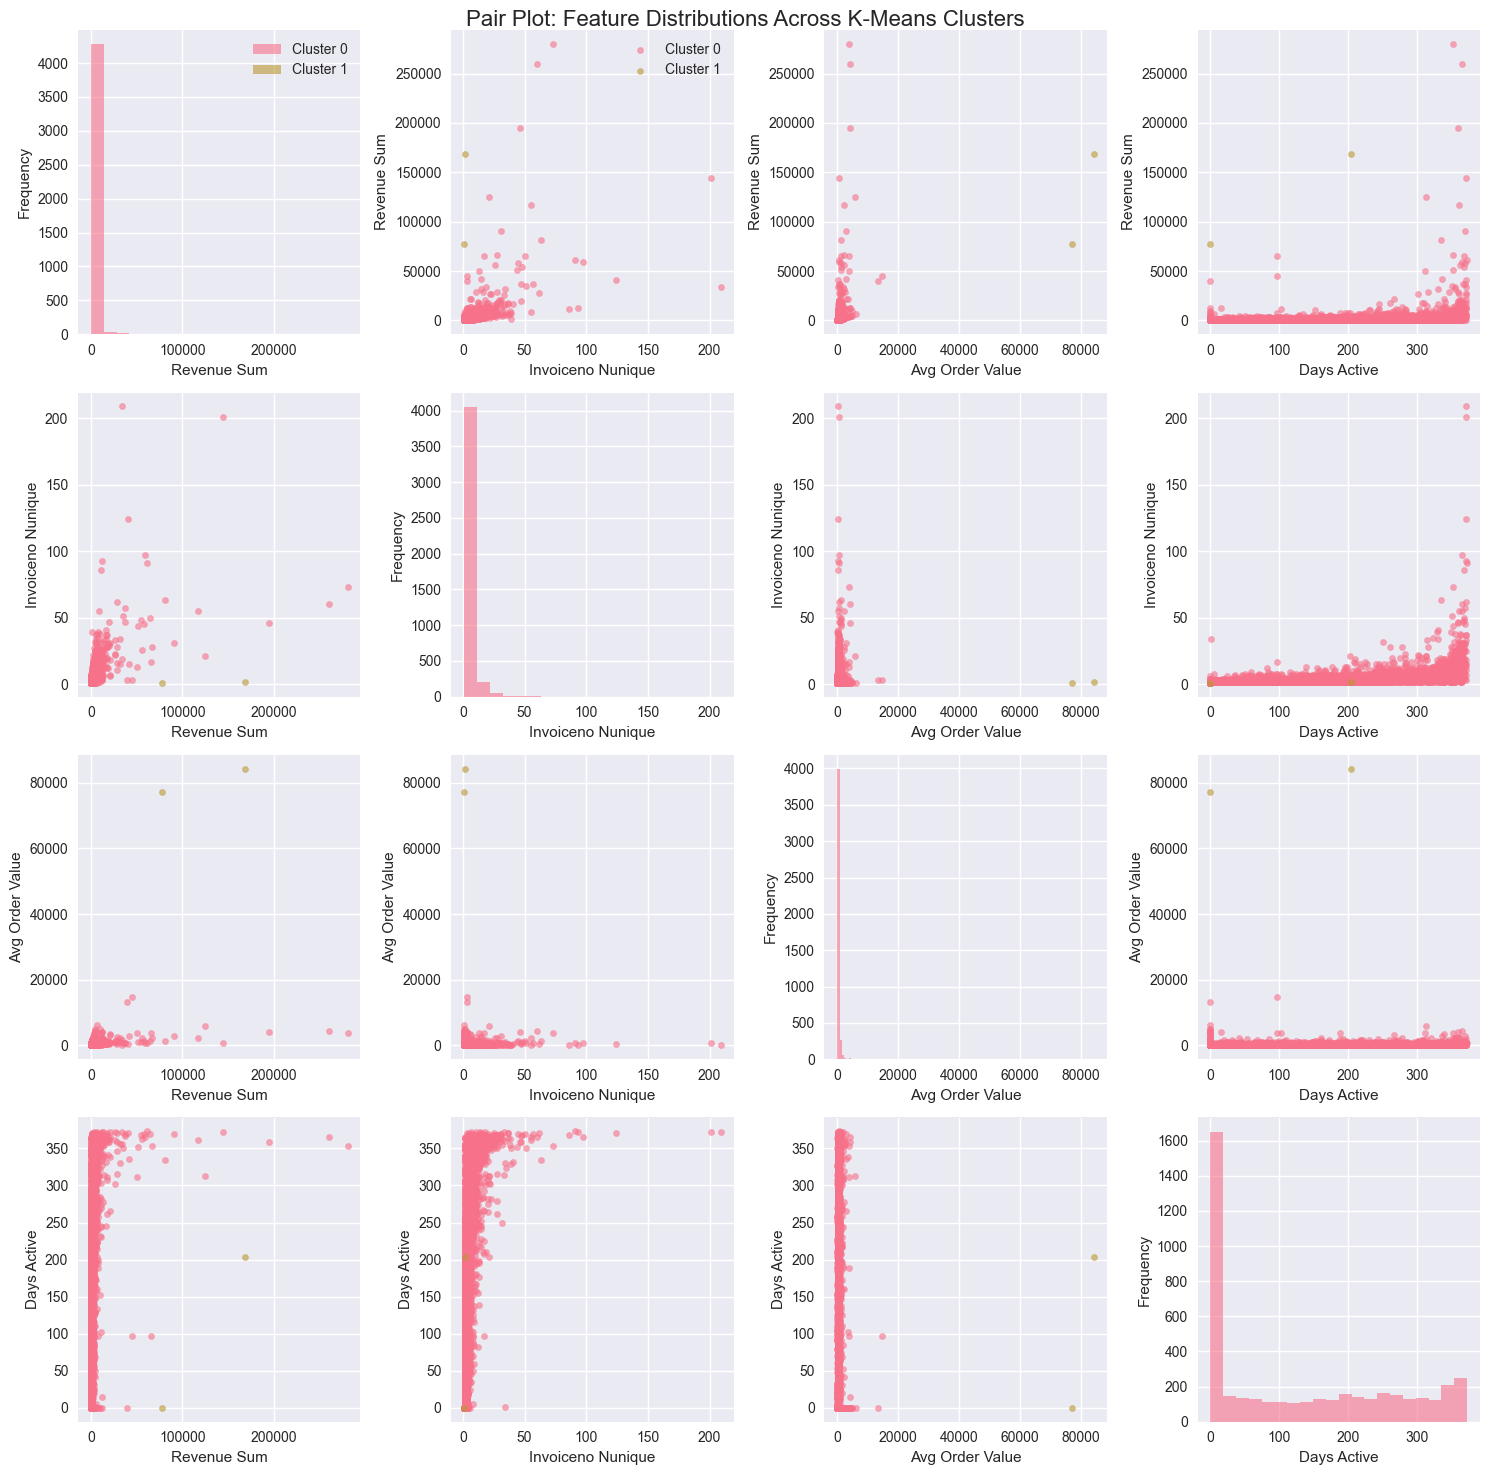

In [16]:
# 3. Pair Plot - Compare distributions across clusters
plt.figure(figsize=(15, 10))

# Select a subset of features for pair plot
pair_features = ['Revenue_sum', 'InvoiceNo_nunique', 'avg_order_value', 'days_active']
pair_data = customer_features[pair_features + ['kmeans_cluster']].copy()

# Create pair plot
n_features = len(pair_features)
fig, axes = plt.subplots(n_features, n_features, figsize=(15, 15))

for i in range(n_features):
    for j in range(n_features):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: histogram
            for cluster in sorted(pair_data['kmeans_cluster'].unique()):
                cluster_data = pair_data[pair_data['kmeans_cluster'] == cluster][pair_features[i]]
                ax.hist(cluster_data, alpha=0.6, label=f'Cluster {cluster}', bins=20)
            ax.set_xlabel(pair_features[i].replace('_', ' ').title())
            ax.set_ylabel('Frequency')
            if i == 0:
                ax.legend()
        else:
            # Off-diagonal: scatter plot
            for cluster in sorted(pair_data['kmeans_cluster'].unique()):
                cluster_data = pair_data[pair_data['kmeans_cluster'] == cluster]
                ax.scatter(cluster_data[pair_features[j]], cluster_data[pair_features[i]], 
                          alpha=0.6, label=f'Cluster {cluster}', s=20)
            ax.set_xlabel(pair_features[j].replace('_', ' ').title())
            ax.set_ylabel(pair_features[i].replace('_', ' ').title())
            if i == 0 and j == 1:
                ax.legend()

plt.suptitle('Pair Plot: Feature Distributions Across K-Means Clusters', fontsize=16)
plt.tight_layout()
plt.savefig('visualizations/pair_plot.png', dpi=300, bbox_inches='tight')
plt.show()


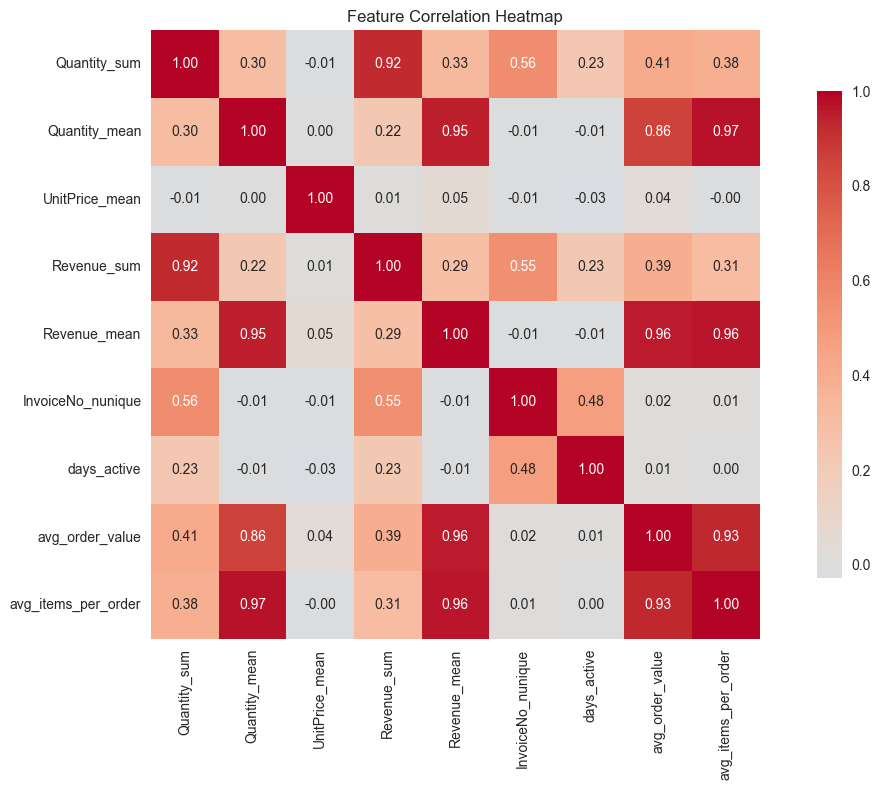

In [20]:
# Correlation heatmap for cluster analysis
plt.figure(figsize=(12, 8))

# Create correlation matrix for selected features
correlation_matrix = customer_features[selected_features].corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('visualizations/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
